In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from dplearning_second_part.limu_dplearning.utils.useful_func import tokenize_nmt, Vocal, build_array_nmt, \
    preprocess_nmt, read_data_nmt

src, tgt = tokenize_nmt(preprocess_nmt(read_data_nmt()),num_examples=600)
src_vocab = Vocal(src, min_feq=2,
                  reserved_tokens=['<pad>', '<bos>', '<eos>'])
tgt_vocab = Vocal(tgt, min_feq=2,
                  reserved_tokens=['<pad>', '<bos>', '<eos>'])
src_data, src_valid = build_array_nmt(src, src_vocab, 10)
tgt_data, tgt_valid = build_array_nmt(tgt, tgt_vocab, 10)
dataset = torch.utils.data.TensorDataset(src_data, src_valid, tgt_data, tgt_valid)
## 训练数据
train_data = torch.utils.data.DataLoader(dataset=dataset, batch_size=32, shuffle=False)

In [72]:
# 掩蔽softmax实现
def sequence_mask(X,valid_len, value=0):
    """X必须为2维batch_size* num_steps，valid_len必须为1维batch
       意味着 第i个batch_size的序列有效长度为 valid_len[i]
    """
    if X.dim() != 2 or valid_len.dim() != 1:
        raise ValueError('Expect 2d tensor')
    # 获取num_steps长度
    maxlen = X.shape[1]
    # 生成顺序序列，用于与valid_len比较
    mask = torch.unsqueeze(torch.arange(0, maxlen, dtype=torch.long),dim=0)
    # 判断需要掩码的部分，这里必须要保证mask和vilid_len形状相等 否则会出问题
    mask = (mask<valid_len.unsqueeze(1).repeat(1, maxlen))
    X[~mask] = value
    return X

def masked_softmax(X,valid_lens=None):
    """通过在最后一个轴上掩蔽元素来执行softmax操作
    注意：X是三维的 一般是 B Q K-V数量
     掩码的目的在于 避免Q关注到无关的或者禁止的K-V
    """
    if valid_lens is None:
        return F.softmax(X, dim=-1)
    shape=X.shape
    # valid_lens可以是1d或者2d 如果是1d则必须长为B 如果是2d则必须是B*Q
    if valid_lens.dim() == 1:
        # 如果是1d则扩展成2d 形状B Q 
        valid_lens = valid_lens.unsqueeze(1).repeat(1, shape[1])
    # 因为sequence函数要求的X是2d valid_lens是1d
    X=X.reshape(-1,shape[-1])
    valid_lens=valid_lens.reshape(-1)
    X_mask=sequence_mask(X, valid_lens,value=-1e6)
    # 完事之后还要把输出的形状转为X原本的形状 
    return F.softmax(X_mask, dim=-1).reshape(shape)

In [5]:

# 位置编码
class PositionalEncoding(nn.Module):
    """位置编码"""
    def __init__(self, num_hiddens, dropout=0.1, max_len=1000):
        super(PositionalEncoding, self).__init__()
        # 创建一个足够长的P 长是指第2个维度 第一个维度应该是batch_size
        # 每一个batch用的是一套位置编码 如果不用一套的话就无法学习到位置信息泛化能力极差
        self.P=torch.zeros(1,max_len,num_hiddens)
        self.dropout = nn.Dropout(dropout)
        X=torch.arange(max_len,dtype=torch.float32).reshape(-1,1)/\
            torch.pow(10000,torch.arange(0,num_hiddens,2)/num_hiddens)
        self.P[:,:,0::2]=torch.sin(X)
        self.P[:,:,1::2]=torch.cos(X)
    def forward(self, X):
        X = X+self.P[:,:X.shape[1],:].to(X.device)
        return self.dropout(X)


# 先实现一个点积注意力
class DotProductAttention(nn.Module):
    def __init__(self, dropout=0.2):
        super(DotProductAttention, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.attention_weights = None
    # q(b,step,embed_size)
    # k(b,键值对个数,embed_size)
    # v(b,键值对个数,embed_size)
    def forward(self, q, k, v,valid_lens):
        attn_weights = torch.bmm(q, k.transpose(1, 2))/torch.sqrt(torch.tensor(q.shape[-1]))
        self.attention_weights=masked_softmax(attn_weights,valid_lens)
        return torch.bmm(self.dropout(self.attention_weights), v)

#@save
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    # qkv各自的embed_size, 隐藏层大小 头数量
    # 需要并行运算多个头 因此num_hiddens 必须能够整除以num_heads
    def __init__(self,key_size,query_size,value_size,num_hiddens,num_heads,dropout,bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q=nn.Linear(query_size,num_hiddens,bias=bias)
        self.W_k=nn.Linear(key_size,num_hiddens,bias=bias)
        self.W_v=nn.Linear(value_size,num_hiddens,bias=bias)
        self.W_o=nn.Linear(num_hiddens,num_hiddens,bias=bias)

    def forward(self, q, k, v,valid_lens=None):

        queries=self.W_q(q)
        keys=self.W_k(k)
        values=self.W_v(v)

        # 在这一步需要对qkv拆分为多头 并行计算attention
        queries=queries.reshape(queries.shape[0],queries.shape[1],self.num_heads,-1).permute(0,2,1,3)
        keys=keys.reshape(keys.shape[0],keys.shape[1],self.num_heads,-1).permute(0,2,1,3)
        values=values.reshape(values.shape[0],values.shape[1],self.num_heads,-1).permute(0,2,1,3)

        queries=queries.reshape(-1,queries.shape[2],queries.shape[3])
        keys=keys.reshape(-1,keys.shape[2],keys.shape[3])
        values=values.reshape(-1,values.shape[2],values.shape[3])

        if valid_lens is not None:
            # 在轴0，将第一项（标量或者矢量）复制num_heads次，
            # 然后如此复制第二项，然后诸如此类。
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)

        attn_weights=self.attention(queries,keys,values,valid_lens)
        attn_weights=attn_weights.reshape(-1,self.num_heads,attn_weights.shape[1],attn_weights.shape[2])
        attn_weights=attn_weights.permute(0,2,1,3)
        attn_weights=attn_weights.reshape(attn_weights.shape[0],attn_weights.shape[1],-1)

        return self.W_o(attn_weights)


In [6]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self,ffn_num_input,ffn_num_hiddens,ffn_num_outputs,**kwargs):
        super(PositionWiseFFN,self).__init__(**kwargs)
        self.dense1=nn.Linear(ffn_num_input,ffn_num_hiddens)
        self.relu=nn.ReLU()
        self.dense2=nn.Linear(ffn_num_hiddens,ffn_num_outputs)
    def forward(self,x):
        return self.dense2(self.relu(self.dense1(x)))

In [7]:
ffn=PositionWiseFFN(ffn_num_input=4,ffn_num_hiddens=4,ffn_num_outputs=8)
ffn.eval()
ffn(torch.ones((2,3,4))).shape

torch.Size([2, 3, 8])

In [8]:
# 残差连接和层规范化

In [9]:
ln = nn.LayerNorm(2)
bn = nn.BatchNorm1d(2)

In [10]:
x=torch.tensor([[1,2],[2,3]],dtype=torch.float32)
x,x.shape

(tensor([[1., 2.],
         [2., 3.]]),
 torch.Size([2, 2]))

In [11]:
# 残差连接和层规范化
class AddNorm(nn.Module):
    def __init__(self,normalized_shape,dropout,**kwargs):
        super(AddNorm,self).__init__()
        self.dropout=nn.Dropout(dropout)
        self.ln=nn.LayerNorm(normalized_shape)
        
    def forward(self,X,Y):
        return self.ln(self.dropout(Y) + X)

In [12]:
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()

AddNorm(
  (dropout): Dropout(p=0.5, inplace=False)
  (ln): LayerNorm((3, 4), eps=1e-05, elementwise_affine=True)
)

In [13]:
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

In [14]:
class EncoderBlock(nn.Module):
    def __init__(self,key_size,query_size,value_size,num_hiddens,norm_shape
                 ,ffn_num_input,ffn_num_hiddens,num_heads,dropout,use_bias=False,**kwargs):
        super(EncoderBlock,self).__init__()
        self.attention = MultiHeadAttention(key_size,query_size,value_size,num_hiddens,num_heads,dropout,bias=use_bias)
        self.addnorm1=AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input,ffn_num_hiddens,num_hiddens,**kwargs)
        self.addnorm2=AddNorm(norm_shape, dropout)
        
    def forward(self,X,valid_lens):
        Y=self.addnorm1(X,self.attention(X,X,X,valid_lens))
        return self.addnorm2(Y,self.ffn(Y))

In [86]:
x=torch.ones((2,100,24))
valid_lens=torch.tensor([3,2])
encoder_blk=EncoderBlock(key_size=24,query_size=24,value_size=24,num_hiddens=24,norm_shape=[100,24],ffn_num_input=24,ffn_num_hiddens=48,num_heads=8,dropout=0.5)
encoder_blk.eval()

EncoderBlock(
  (attention): MultiHeadAttention(
    (attention): DotProductAttention(
      (dropout): Dropout(p=0.5, inplace=False)
    )
    (W_q): Linear(in_features=24, out_features=24, bias=False)
    (W_k): Linear(in_features=24, out_features=24, bias=False)
    (W_v): Linear(in_features=24, out_features=24, bias=False)
    (W_o): Linear(in_features=24, out_features=24, bias=False)
  )
  (addnorm1): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
  (ffn): PositionWiseFFN(
    (dense1): Linear(in_features=24, out_features=48, bias=True)
    (relu): ReLU()
    (dense2): Linear(in_features=48, out_features=24, bias=True)
  )
  (addnorm2): AddNorm(
    (dropout): Dropout(p=0.5, inplace=False)
    (ln): LayerNorm((100, 24), eps=1e-05, elementwise_affine=True)
  )
)

In [16]:
encoder_blk(x,valid_lens).shape

torch.Size([2, 100, 24])

In [17]:
encoder_blk.attention.attention.attention_weights

tensor([[[0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         ...,
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000]],

        [[0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.0000],
         [0.3333, 0.3333, 0.3333,  ..., 0.0000, 0.0000, 0.

In [18]:
class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder,self).__init__()
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size,num_hiddens)
        self.pos_encoding=PositionalEncoding(num_hiddens,dropout)
        self.blks=nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i)
                                 ,EncoderBlock(key_size,query_size,value_size,num_hiddens
                                               ,norm_shape,ffn_num_input,ffn_num_hiddens
                                               ,num_heads,dropout,use_bias))
    def forward(self,X,valid_lens,*args):
        # 因为位置编码值在-1和1之间，
        # 因此嵌入值乘以嵌入维度的平方根进行缩放， 因为嵌入层会把整个层的元素都压缩在均值为0方差为1的分布中 
        # 因此当num_hiddens越大单个值会越小所以这么乘 保证每个元素也是在-1 1之间
        # 然后再与位置编码相加。
        X=self.pos_encoding(self.embedding(X)*torch.sqrt(torch.tensor(self.num_hiddens)))
        self.attention_weights = [None] * len(self.blks)
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[
                i] = blk.attention.attention.attention_weights
        return X

In [19]:
encoder = TransformerEncoder(
    200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

In [92]:
class DecoderBlock(nn.Module):
    """解码器中的第i个块"""
    def __init__(self,key_size,query_size,value_size,num_hiddens,norm_shape
                 ,ffn_num_input,ffn_num_hiddens,num_heads,dropout,i,**kwargs):
        super(DecoderBlock,self).__init__()
        self.i=i
        self.attention1=MultiHeadAttention(key_size,query_size,value_size,num_hiddens,num_heads,dropout)
        self.addnorm1=AddNorm(norm_shape, dropout)
        self.attention2=MultiHeadAttention(key_size,query_size,value_size,num_hiddens,num_heads,dropout)
        self.addnorm2=AddNorm(norm_shape,dropout)
        self.ffn=PositionWiseFFN(ffn_num_input,ffn_num_hiddens,num_hiddens,**kwargs)
        self.addnorm3=AddNorm(norm_shape, dropout)
    def forward(self,X,state):
        """X每次的输入 可能是初始输入也可能是上次的输出 形状B L H
            state: 一个包含解码器运行状态的列表。
            state[0]: enc_outputs - 编码器的最终输出。这个在整个解码过程中都是固定的。形状： (batch_size, enc_num_steps, num_hiddens)。
            state[1]: enc_valid_lens - 编码器输入的有效长度。用于对编码器输出进行填充掩码。形状： (batch_size,)。
            state[2]: 一个列表，用于存储每个解码器块在自注意力层中积累的键值对历史。这对于高效的**序列生成（推理）**至关重要。
            """
        enc_outputs,enc_valid_lens=state[0],state[1]
        if state[2][self.i] is None:
            key_values=X
        else:# 其实这里主要是推理时发挥作用 因为训练时传入的是一个完成的X 直接复制给key_values
            # 这个key_values每次都会叠加 叠加的是本次的X
            key_values=torch.cat((state[2][self.i],X),dim=1)
        state[2][self.i]=key_values
        if self.training:
            batch_size,num_steps,_=X.shape
            # dec_valid_lens的开头:(batch_size,num_steps),其中每一行是[1,2,...,num_steps] 处理后就变成 batch_size*num_steps的矩阵了
            # 基于这个valid_lens矩阵，训练状态下会生成一个解码有效长度目的是最后得到一个下三角矩阵 保证每一步x只能关注到当前之前步的编码
            dec_valid_lens=torch.arange(1,num_steps+1,device=X.device).repeat(batch_size,1)
        else:
            dec_valid_lens=None

        # 自注意力
        X2 = self.attention1(X,key_values,key_values,dec_valid_lens)
        Y = self.addnorm1(X,X2)
        # 编码器-解码器注意力
        # enc_outputs 形状（batch_size,num_steps,num_hiddens）
        Y2 = self.attention2(Y,enc_outputs,enc_outputs,enc_valid_lens)
        Z = self.addnorm2(Y,Y2)
        return self.addnorm3(Z,self.ffn(Z)),state


In [93]:
decoder_blk=DecoderBlock(key_size=24,query_size=24,value_size=24,num_hiddens=24,norm_shape=[100,24],ffn_num_input=24,ffn_num_hiddens=48,num_heads=4,dropout=0.5,i=0)
decoder_blk.eval()
X=torch.ones((2,100,24))
state=[encoder_blk(X,valid_lens),valid_lens,[None]]
state[0].shape,decoder_blk(X, state)[0].shape

In [119]:
class TransformerDecoder(nn.Module):
    def __init__(self,vocab_size,key_size,query_size,value_size,num_hiddens,norm_shape,ffn_num_input,ffn_num_hiddens,num_heads,num_layers,dropout,**kwargs):
        super(TransformerDecoder,self).__init__()
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size,num_hiddens)
        self.pos_encoding=PositionalEncoding(num_hiddens,dropout)
        self.blks=nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module('block'+str(i),
                                 DecoderBlock(key_size,query_size,value_size,num_hiddens,norm_shape,ffn_num_input,ffn_num_hiddens,num_heads,dropout,i))
        self.dense=nn.Linear(num_hiddens,vocab_size)
    def init_state(self,enc_outputs,enc_valid_lens,*args):
        return [enc_outputs,enc_valid_lens,[None]*self.num_layers]
    
    def forward(self,X,state):
        # 将X放大避免整个embeding 被位置编码的大小淹没 因为位置编码是-1 1之间
        X = self.pos_encoding(self.embedding(X)*torch.sqrt(torch.tensor(self.num_hiddens)))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i,blk in enumerate(self.blks):
            X,state = blk(X, state)
            # 保留自注意力权重信息
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # 保留编码解码注意力权重
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
            
        return self.dense(X),state
        
    @property
    def attention_weights(self):
        return self._attention_weights

In [126]:
num_hiddens,num_layers,dropout,batch_size,num_steps=32,2,0.1,64,10
lr,num_epochs,device=0.005,200,'cpu'
ffn_num_input=32
ffn_num_hiddens=64
num_heads=4
key_size,query_size,value_size=32,32,32
norm_shape=[32]

In [128]:
encoder = TransformerEncoder(
    len(src_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)
decoder = TransformerDecoder(
    len(tgt_vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout)

In [136]:
class EncoderDecoder(nn.Module):
    def __init__(self,encoder,decoder):
        super(EncoderDecoder,self).__init__()
        self.encoder = encoder
        self.decoder = decoder
    def forward(self,enc_x,dec_x,*args):
        enc_outputs=self.encoder(enc_x)
        state=self.decoder.init_state(enc_outputs,*args)
        dec_outputs=self.decoder(dec_x,state)
        return dec_outputs

In [137]:
net = EncoderDecoder(encoder, decoder)

In [138]:
from torch import optim

# train
optimizer = optim.Adam(net.parameters(), lr=0.005)
for epoch in range(300):
    for batch in train_data:
        optimizer.zero_grad()
        
        src,src_valid,tgt,tgt_valid=batch
        Y=torch.cat((torch.tensor([tgt_vocab['<bos>']]).unsqueeze(0).repeat(tgt.shape[0],1),tgt),dim=1)[:,:-1]
        # 易错点1：训练的时候应该使用带有bos的Y 表示强制教学 此时输出的y_hat实际上是没有bos的
        y_hat,_=net(src,Y,src_valid)
        # 点2 因为输出的y_hat 没有bos 因此在计算loss的时候应该使用原始序列作为目标序列
        l=loss(y_hat,tgt,tgt_valid).sum()
        l.backward()
        grad_clipping(net, 1)
        optimizer.step()
    print(l)

TypeError: TransformerEncoder.forward() missing 1 required positional argument: 'valid_lens'

ValueError: too many values to unpack (expected 2)

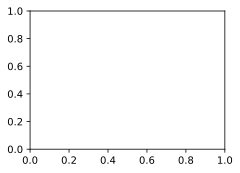